<a href="https://colab.research.google.com/github/Bhagyasrisatya7/E-commerce/blob/main/e_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()


Saving e-commerce.csv to e-commerce.csv


In [23]:
import pandas as pd
df = pd.read_csv("e-commerce.csv", encoding='ISO-8859-1')
df.columns = df.columns.str.strip().str.lower()
df.head()

,customer no.,row id,order priority,discount,unit price,shipping cost,customer id,customer name,ship mode,customer segment,...,region,state or province,city,postal code,order date,ship date,profit,quantity ordered new,sales,order id
0,1,18606,Not Specified,0.01,2.88,0.50,2,Janice Fletcher,Regular Air,Corporate,...,Central,Illinois,Addison,60101,5/28/2012,5/30/2012,1.3200,2,5.90,88525
1,2,20847,High,0.01,2.84,0.93,3,Bonnie Potter,Express Air,Corporate,...,West,Washington,Anacortes,98221,7/7/2010,7/8/2010,4.5600,4,13.01,88522
2,3,23086,Not Specified,0.03,6.68,6.15,3,Bonnie Potter,Express Air,Corporate,...,West,Washington,Anacortes,98221,7/27/2011,7/28/2011,-47.6400,7,49.92,88523
3,4,23087,Not Specified,0.01,5.68,3.60,3,Bonnie Potter,Regular Air,Corporate,...,West,Washington,Anacortes,98221,7/27/2011,7/28/2011,-30.5100,7,41.64,88523
4,5,23088,Not Specified,0.00,205.99,2.50,3,Bonnie Potter,Express Air,Corporate,...,West,Washington,Anacortes,98221,7/27/2011,7/27/2011,998.2023,8,1446.67,88523


In [24]:
df.dropna(inplace=True)

df.rename(columns={
    'unit price': 'unit_price',
    'quantity ordered new': 'quantity',
    'sales': 'sales_value',
    'order date': 'order_date',
    'customer id': 'customer_id'
}, inplace=True)

df['order_date'] = pd.to_datetime(df['order_date'])

df['total_price'] = df['quantity'] * df['unit_price']

df[['customer_id', 'quantity', 'unit_price', 'sales_value', 'total_price']].head()


,customer_id,quantity,unit_price,sales_value,total_price
0,2,2,2.88,5.90,5.76
1,3,4,2.84,13.01,11.36
2,3,7,6.68,49.92,46.76
3,3,7,5.68,41.64,39.76
4,3,8,205.99,1446.67,1647.92


In [12]:
customer_df = df.groupby('customer_id').agg({
    'order id': 'nunique',
    'quantity': 'sum',
    'unit_price': 'mean',
    'total_price': 'sum'
}).reset_index()

customer_df.columns = ['customer_id', 'total_orders', 'total_quantity', 'avg_unit_price', 'total_revenue']
customer_df.head()


,customer_id,total_orders,total_quantity,avg_unit_price,total_revenue
0,2,1,2,2.880000,5.76
1,3,4,75,66.273333,5250.20
2,5,2,30,253.730000,6128.40
3,6,2,61,46.887500,3615.80
4,7,1,19,12.280000,233.32


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = customer_df[['total_orders', 'total_quantity', 'avg_unit_price', 'total_revenue']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
customer_df['cluster'] = kmeans.fit_predict(X_scaled)


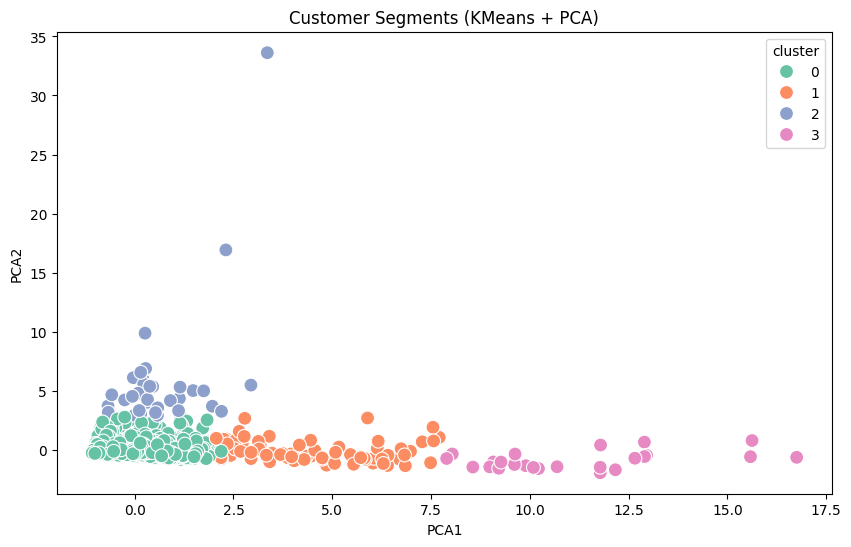

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
customer_df['PCA1'] = components[:, 0]
customer_df['PCA2'] = components[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=customer_df, palette='Set2', s=100)
plt.title("Customer Segments (KMeans + PCA)")
plt.show()


Accuracy: 0.9171817058096415

Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       587
           1       0.84      0.87      0.85       222

    accuracy                           0.92       809
   macro avg       0.89      0.90      0.90       809
weighted avg       0.92      0.92      0.92       809



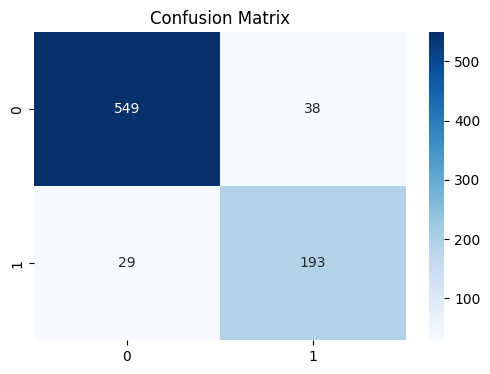

In [15]:
threshold = customer_df['total_revenue'].mean()
customer_df['high_value'] = (customer_df['total_revenue'] > threshold).astype(int)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = customer_df[['total_orders', 'total_quantity', 'avg_unit_price']]
y = customer_df['high_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
plt.title("Confusion Matrix")
plt.show()


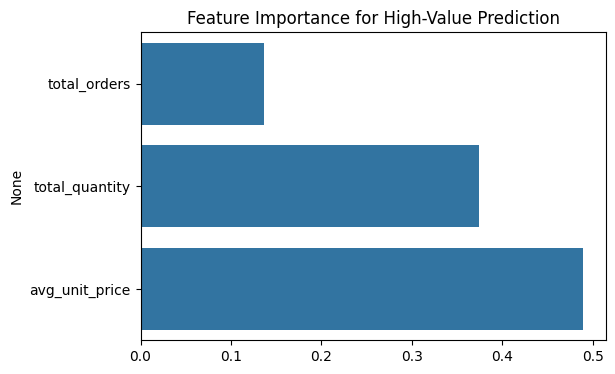

In [16]:
importances = clf.feature_importances_
features = X.columns

plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance for High-Value Prediction")
plt.show()


In [17]:
latest_date = df['order_date'].max()

rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (latest_date - x.max()).days,  # Recency
    'order id': 'nunique',                                  # Frequency
    'total_price': 'sum'                                    # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

rfm.head()

,customer_id,recency,frequency,monetary
0,2,582,1,5.76
1,3,183,4,5250.20
2,5,598,2,6128.40
3,6,367,2,3615.80
4,7,427,1,233.32


In [18]:
rfm['r_score'] = pd.qcut(rfm['recency'], 4, labels=[4,3,2,1])
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['m_score'] = pd.qcut(rfm['monetary'], 4, labels=[1,2,3,4])

rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

def segment(score):
    if score == '444':
        return 'Champions'
    elif score[0] == '4':
        return 'Loyal'
    elif score[1] == '4':
        return 'Frequent Buyer'
    elif score[2] == '4':
        return 'Big Spender'
    else:
        return 'Others'

rfm['segment'] = rfm['rfm_score'].apply(segment)
rfm.head()


,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
0,2,582,1,5.76,2,1,1,211,Others
1,3,183,4,5250.20,3,3,4,334,Big Spender
2,5,598,2,6128.40,2,2,4,224,Big Spender
3,6,367,2,3615.80,2,2,4,224,Big Spender
4,7,427,1,233.32,2,1,1,211,Others


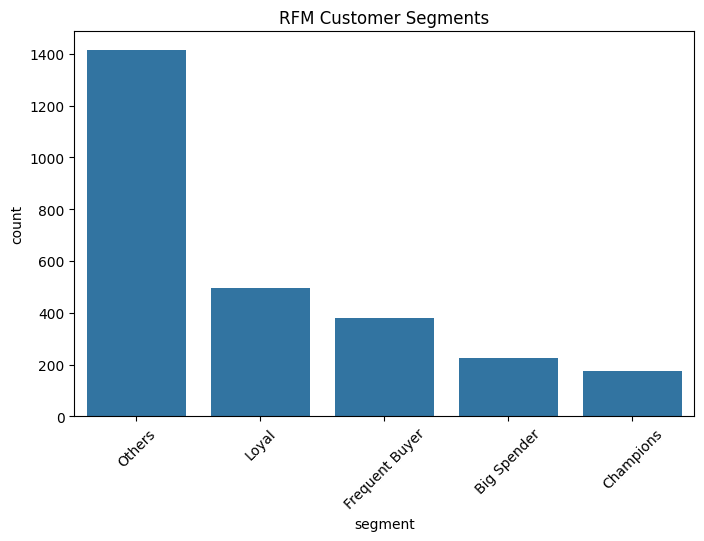

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='segment', order=rfm['segment'].value_counts().index)
plt.title("RFM Customer Segments")
plt.xticks(rotation=45)
plt.show()


In [20]:
full_df = pd.merge(customer_df, rfm[['customer_id', 'segment']], on='customer_id', how='left')
full_df.head()


,customer_id,total_orders,total_quantity,avg_unit_price,total_revenue,cluster,PCA1,PCA2,high_value,segment
0,2,1,2,2.880000,5.76,0,-1.068749,-0.278428,0,Others
1,3,4,75,66.273333,5250.20,0,0.707958,-0.212230,1,Big Spender
2,5,2,30,253.730000,6128.40,0,-0.020171,0.954091,1,Big Spender
3,6,2,61,46.887500,3615.80,0,-0.092947,-0.160034,1,Big Spender
4,7,1,19,12.280000,233.32,0,-0.933906,-0.252704,0,Others


In [21]:
pd.crosstab(full_df['cluster'], full_df['segment'], margins=True)


segment,Big Spender,Champions,Frequent Buyer,Loyal,Others,All
cluster,,,,,,
0,202,121,335,490,1411,2559
1,5,35,35,2,0,77
2,18,3,3,5,5,34
3,0,18,6,0,0,24
All,225,177,379,497,1416,2694


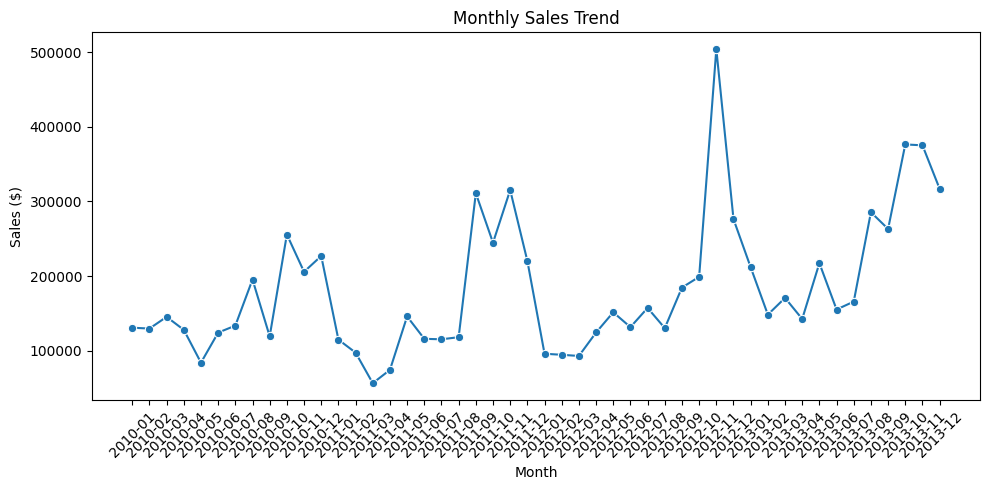

In [22]:
df['order_month'] = df['order_date'].dt.to_period('M').astype(str)
monthly_sales = df.groupby('order_month')['sales_value'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_sales, x='order_month', y='sales_value', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.ylabel("Sales ($)")
plt.xlabel("Month")
plt.tight_layout()
plt.show()
